# Activations and Gradients and BatchNorm

In [1]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [11]:
# read in all the words
words = open('C:/Users/preet/Documents/Keep_Project/names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [106]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i+1:s for i,s in enumerate(chars)}
itos[0] = '.'

vocab_size = 27

In [107]:
[0]*3

[0, 0, 0]

In [108]:
block_size = 3

def build_dataset(words):
    X,Y = [], []
    
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y
            
# create sets
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [109]:
# MLP

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility

C  = torch.randn((vocab_size, n_embd),            generator=g)   
# 27x20 matrix -> each letter gets 10 numbers

W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2 

#the reason we have n_emb * block_size is because we want to concatinate the examples. Instead of a 3x10 matrix for one example
# I want to make it a 1x 30 matrix, each example in one row.


b1 = torch.randn(n_hidden,                        generator=g) * 0.01


W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
# the input into this layer is -> 1X200 
# this weight is 200 x 27 
# the output is 1x 27 vector which would be a probabilty of a letter out of the 27

b2 = torch.randn(vocab_size,                      generator=g) * 0


parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True
    
    


In [110]:
max_steps = 200000
batch_size = 32
lossi = []



for i in range(max_steps):
    # minibatch contruct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # its interesting that these are just 32 random example from the dataset. it is possible that some of the examples are not even in the training set???
    
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    # this is embeding each letter to a 1x10 vector
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # remember we what each example to be one row. this makes each example one row
    
    # forward pass:
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) # activation is tanh
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    lossi.append(loss.log10().item())
  
    
    
    

      0/ 200000: 3.2919
  10000/ 200000: 2.3768
  20000/ 200000: 2.2040
  30000/ 200000: 2.1786
  40000/ 200000: 2.0913
  50000/ 200000: 2.0421
  60000/ 200000: 1.9533
  70000/ 200000: 2.2160
  80000/ 200000: 1.9516
  90000/ 200000: 2.0229
 100000/ 200000: 1.8910
 110000/ 200000: 1.8692
 120000/ 200000: 2.0451
 130000/ 200000: 2.0751
 140000/ 200000: 1.7027
 150000/ 200000: 2.0493
 160000/ 200000: 1.6198
 170000/ 200000: 1.7937
 180000/ 200000: 2.1341
 190000/ 200000: 1.7599


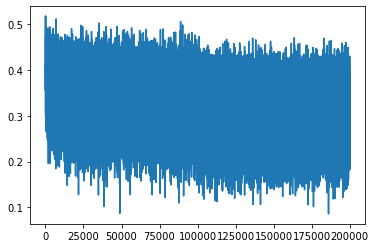

In [111]:
plt.plot(lossi)

In [ ]:
@torch.no_grad()
def split_loss(split):
    x,y = {'train': (Xtr, Ytr),
           'val': (Xdev, Ydev),
           'test': (Xte, Yte),
          }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
    

In [59]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

carman.
ambrilli.
kimri.
ree.
cassanden.
jazhith.
delynn.
jareei.
ner.
kiah.
maihvik.
leggy.
ham.
pois.
quint.
suline.
livebi.
wanell.
dearisi.
jaxen.


# We want the intial loss to be lower, what is the loss for uniform distribution:


- you will always have a rough idea as to what is the loss function
- you have no reason to belive that any letter is one letter more likely than others

In [60]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

- we want the logits to be closer to 0 to give us the appropriate loss
- our function is very wrong, confindently wrong

In [61]:
# this loss is uniform

logits = torch.tensor([0.0,0.0,0.0,0.0])
probs = torch.softmax(logits,dim=0)
loss = -probs[2].log()
probs,loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In [62]:
# this loss means there is high probability the 2 index and it is correct so the loss is low

logits = torch.tensor([0.0,0.0,5,0.0])
probs = torch.softmax(logits,dim=0)
loss = -probs[2].log()
probs,loss

(tensor([0.0066, 0.0066, 0.9802, 0.0066]), tensor(0.0200))

In [63]:
# this loss means there is a low proabbilty the 3 but that is the right answer that gives us high loss

logits = torch.tensor([0.0,0.0,0.0,5])
probs = torch.softmax(logits,dim=0)
loss = -probs[2].log()
probs,loss

(tensor([0.0066, 0.0066, 0.0066, 0.9802]), tensor(5.0200))

In [77]:
# extreame values, so high losses

logits = torch.randn(4)*10
probs = torch.softmax(logits,dim=0)
loss = -probs[2].log()
logits, probs,loss

(tensor([-18.3367,  -9.3269,  -2.2980,   8.8802]),
 tensor([1.5130e-12, 1.2381e-08, 1.3975e-05, 9.9999e-01]),
 tensor(11.1783))

In our example this is what goes wrong: we have extreme values in our intial weights
We can try to guess good intializations. but this takes too long


What about setting weights to 0? Let look at h tensor to learn why 0 is not a god idea.

h tensor is what comes out of the tanh activation


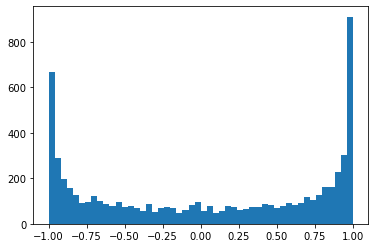

In [78]:
plt.hist(h.view(-1).tolist(),50);
# our values are in the extremes

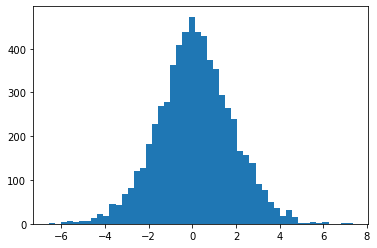

In [79]:
plt.hist(hpreact.view(-1).tolist(),50);
# out preactivations are very broad and tanh squeezes it between -1 and 1

- back propagate through tanh
- the local gradient is 1-t**2; if we plug in t = 1 or -1 it will become 0; it will kill the gradient??
- when its between -1 and 1 there is more numbers



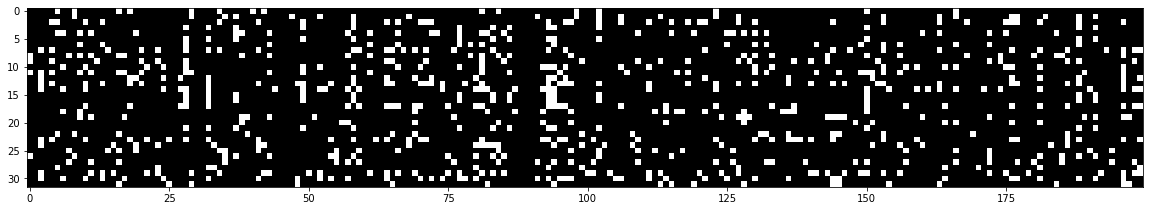

In [80]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99,cmap='gray',interpolation='nearest')

- White if its true and black if its false
- white columns are dead neurons
- means no gradient, neuron will never learn
- the gradient is 0 so when you add on its like not learning
- this applys to relu, sigmoid, tanh activation functions

# how can we make it better


tensor(0.0030) tensor(1.0083)
tensor(0.0082) tensor(3.2674)


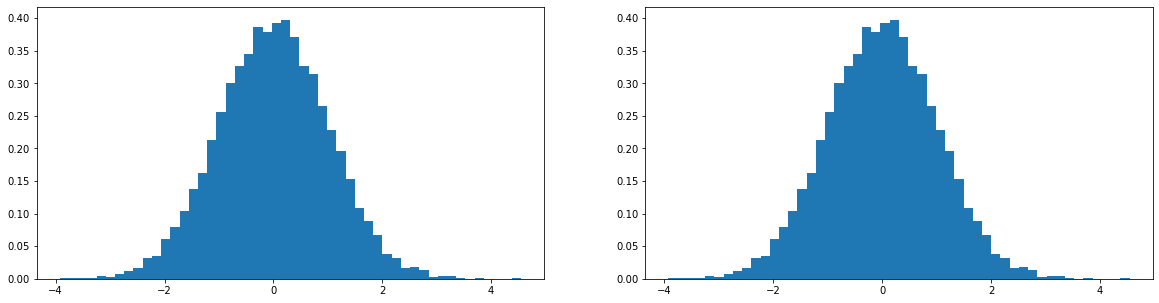

In [34]:
x = torch.randn(1000,10)
w = torch.randn(10,200)
y= x@w
print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50, density=True);
plt.subplot(122)
plt.hist(x.view(-1).tolist(),50, density=True);


- notice how the standard deviation of the new tensor y changes

tensor(-0.0043) tensor(1.0031)
tensor(0.0026) tensor(1.0098)


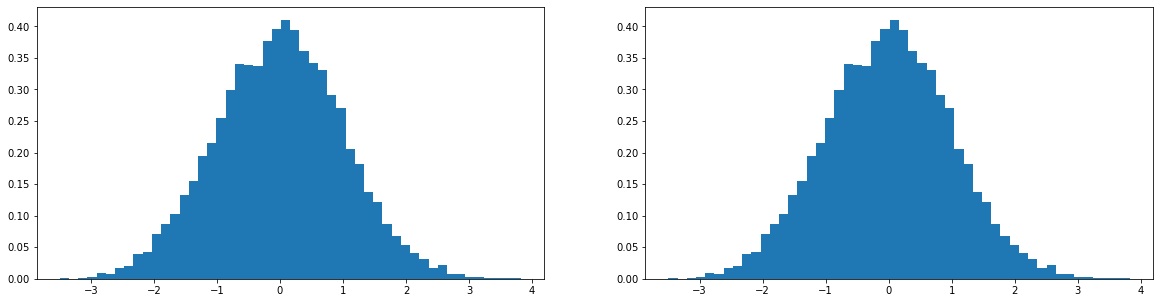

In [35]:
x = torch.randn(1000,10)
w = torch.randn(10,200)/ 10**0.5
y= x@w
print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50, density=True);
plt.subplot(122)
plt.hist(x.view(-1).tolist(),50, density=True);


Kaiming initializations -> the most common
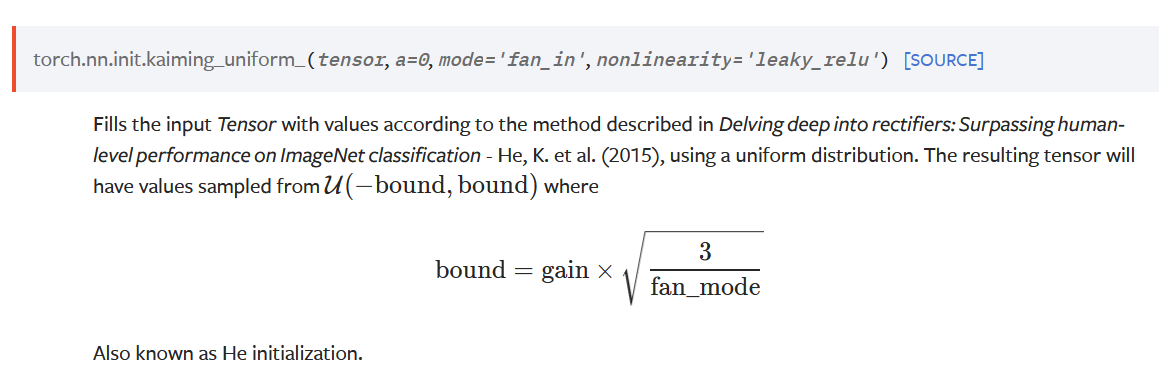


1. know the mode -> do you want nomralize the activations or the gradient: in the paper they found it doesnt matter so just leave it as fan in 
2. nonlinearity -> activation the gain is different 

modern innovations -> residual connections
    -> normalization layers
    -> optimizers: RMSProp, Adama
insilaization maters less



In [36]:
(5/3) / (30**0.5)    # this should be our intialization

0.3042903097250923

# BatchNorm

we want hpreact to be roughly around 0 so why not just normalize it?? -> batchnorm

In [101]:
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))


parameters = [C, W1, b1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True
    

# at intialization the thing will be exactly unit gausssian

In [104]:
max_steps = 200000
batch_size = 32
lossi = []



for i in range(max_steps):
    # minibatch contruct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # its interesting that these are just 32 random example from the dataset. it is possible that some of the examples are not even in the training set???
    
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    # this is embeding each letter to a 1x10 vector
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # remember we what each example to be one row. this makes each example one row
    
    # forward pass:
    hpreact = embcat @ W1 + b1
    
    #Batch-norm
    
    hpreact = bngain*(hpreact - hpreact.mean(0,keepdim=True) / hpreact.std(0,keepdim=True)) + bnbias
    
    # everysingle firing rate will be gaussian but we dont want all of them to be that way all the time, we want some neurons to be more "trigger happy"
    # depedning on the learning. So we introduce scale and shift
    
    
    
    h = torch.tanh(hpreact) # activation is tanh
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    lossi.append(loss.log10().item())
  
    
    

      0/ 200000: 3.1543
  10000/ 200000: 2.0501
  20000/ 200000: 2.2757
  30000/ 200000: 2.0478
  40000/ 200000: 2.1315
  50000/ 200000: 1.9892
  60000/ 200000: 1.9629
  70000/ 200000: 2.2740
  80000/ 200000: 2.0726
  90000/ 200000: 1.8001
 100000/ 200000: 2.2134
 110000/ 200000: 2.2661
 120000/ 200000: 1.8630
 130000/ 200000: 1.9094
 140000/ 200000: 2.0370
 150000/ 200000: 2.2560
 160000/ 200000: 2.0478
 170000/ 200000: 2.2226
 180000/ 200000: 2.0756
 190000/ 200000: 1.9800


In [105]:
hpreact.shape

torch.Size([32, 200])

In [82]:
hpreact.mean(0,keepdim=True).shape

torch.Size([1, 200])

In [83]:
hpreact.std(0,keepdim=True).shape

torch.Size([1, 200])

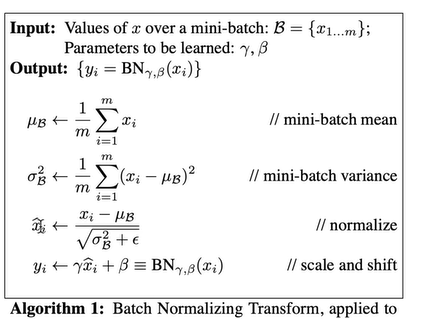